In [8]:
#import data
import pandas as pd
import spacy
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_csv('C:\\Users\\IM_py\\Documents\\GitHub\\Projects\\python_solved_exercises\\NLP\\train.txt', header = None, names = ['tweet','emotion'],sep = ';')
df_test = pd.read_csv('C:\\Users\\IM_py\\Documents\\GitHub\\Projects\\python_solved_exercises\\NLP\\test.txt', header = None, names = ['tweet','emotion'],sep = ';')

df_train.head()

,tweet,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
#turn y to numeric classes
class_dic = {
    'joy': 4,
    'sadness': 1,
    'anger': 2,
    'love': 5,
    'surprise': 3,
    'fear': 0
}

df_train['e_class'] = df_train['emotion'].map(class_dic)
df_test['e_class'] = df_test['emotion'].map(class_dic)

df_train['e_class'].value_counts()

4    5362
1    4666
2    2159
0    1937
5    1304
3     572
Name: e_class, dtype: int64

In [10]:
#tidying data
# remove punctuation and stop words
# apply lemma 

nlp = spacy.load('en_core_web_sm')

def tidying(text):
    doc = nlp(text)

    filtered_list = []

    for token in doc:

        if token.is_stop or token.is_punct:
            continue
        filtered_list.append(token.lemma_)

    return ' '.join(filtered_list)


df_train['prep_tweet'] = df_train['tweet'].apply(tidying)
df_test['prep_tweet'] = df_test['tweet'].apply(tidying)

df_train = df_train.drop(['tweet','emotion'],axis = 1)
df_test = df_test.drop(['tweet','emotion'],axis = 1)

In [11]:
df_train.to_csv('C:\\Users\\IM_py\\Documents\\GitHub\\Projects\\python_solved_exercises\\NLP\\tidy_train.csv')
df_test.to_csv('C:\\Users\\IM_py\\Documents\\GitHub\\Projects\\python_solved_exercises\\NLP\\tidy_test.csv')

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
#run bert
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

def get_sentence_emb(sents):
    prepe = bert_preprocess(sents)
    return bert_encoder(prepe)['pooled_output']

In [13]:
#run classifier
text_input = tf.keras.layers.Input(shape = (),dtype = tf.string, name = 'text')
input_prep = bert_preprocess(text_input)
final_input = bert_encoder(input_prep)

l = tf.keras.layers.Dropout(0.1, name  = 'dropout')(final_input['pooled_output'])
l = tf.keras.layers.Dense(1, activation = 'sigmoid',name = "output")(l)

model = tf.keras.Model(inputs = [text_input], outputs  = [l])

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [15]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='acc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = METRICS)

In [17]:
model.fit(df_train['prep_tweet'],df_train['e_class'], batch_size=32,epochs=1)

500/500 [==============================] - 3424s 7s/step - loss: -211.0872 - acc: 0.2916 - precision: 0.8789 - recall: 1.0000


In [19]:
model.evaluate(df_test['prep_tweet'], df_test['e_class'])

63/63 [==============================] - 340s 5s/step - loss: -336.6400 - acc: 0.2905 - precision: 0.8880 - recall: 1.0000


[-336.6400146484375, 0.2904999852180481, 0.8880000114440918, 1.0]

In [21]:
y_predicted = model.predict(df_test['prep_tweet'])
y_predicted = y_predicted.flatten()

63/63 [==============================] - 353s 6s/step


In [22]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(df_test['e_class'], y_predicted)
cm 

array([[  0, 224,   0,   0,   0,   0],
       [  0, 581,   0,   0,   0,   0],
       [  0, 275,   0,   0,   0,   0],
       [  0,  66,   0,   0,   0,   0],
       [  0, 695,   0,   0,   0,   0],
       [  0, 159,   0,   0,   0,   0]], dtype=int64)

Text(33.0, 0.5, 'Truth')

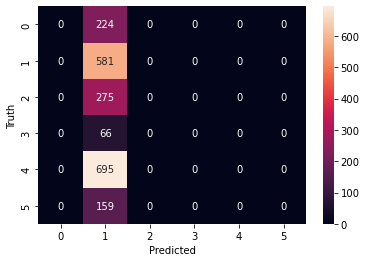

In [25]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')